In [ ]:
! pip install kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install torchvision
!kaggle datasets download -d zalando-research/fashionmnist
!unzip fashionmnist.zip

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision as v
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler  # for validation test
from torch.utils.data import Dataset, TensorDataset

class Data:
    def __init__(self, train_path, test_path):
        """This class will load and make data
        readable for pytorch model."""

        self.train_path = train_path
        self.test_path = test_path

        self.train_data = None
        self.test_data = None

    def load_data(self):
        self.train_data = pd.read_csv(self.train_path)
        self.test_data = pd.read_csv(self.test_path)
        return self.train_path, self.test_path

    def visualize_random_image(self):
        return plt.imshow(np.array(self.train_data.loc[10][1:]).reshape(28, 28))

    def prepare_data(self, batch_size):
        """This function read csv data as tensor and
        return dataloader object for model input"""

        indices = list(range(len(self.train_data.index)))
        np.random.shuffle(indices)
        # to get 20% of the train set
        split = int(np.floor(0.2 * len(self.train_data)))
        train_sample = SubsetRandomSampler(indices[:split])
        valid_sample = SubsetRandomSampler(indices[split:])

        df = torch.from_numpy(np.array(self.train_data))
        # splitting label and data
        df = df.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        df = TensorDataset(df[:, 1:], df[:, 0])
        train = torch.utils.data.DataLoader(df, sampler=train_sample, batch_size=batch_size)
        valid = torch.utils.data.DataLoader(df, sampler=valid_sample, batch_size=batch_size)
        test = torch.utils.data.DataLoader(self.test_data)

        return train, valid, test


In [139]:
import torch.nn as nn
import torch.nn.functional as F


class ANN(nn.Module):
    def __init__(self , dropout=False):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 10)
        self.dropout = nn.Dropout(0.35)
        # self.fc5 = nn.Linear(10, 10)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = (F.relu(self.fc2(x)))
        if(self.dropout):
            x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = (F.relu(self.fc4(x)))
        if(self.dropout):
            x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        if(self.dropout):
            x = self.dropout(x)
        x = F.relu(self.fc7(x))

        output = self.fc8(x)

        return output



In [148]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F


class trainer1:
    def __init__(self, model, epoch, learning_rate, optimizer, loss):
        """Initializing parameters."""
        self.model = model
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.criterion = loss
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_total_step = None
        self.val_total_step = None

        self.val_loss = []
        self.val_acc = []
        self.train_loss = []
        self.train_acc = []

    def train(self, trainset, validset):
        early_stopping = EarlyStopping(10 , 10)
        self.model = self.model.to(self.device)

        self.train_total_step = len(trainset)
        self.val_total_step = len(validset)

        for epoch in range(self.epoch):
            train_running_loss = 0
            train_correct = 0
            train_total = 0

            val_running_loss = 0
            val_correct = 0
            val_total = 0

            loss, train_correct, train_running_loss, train_total = self.run_train_epoch(train_correct,
                                                                                        train_running_loss, train_total,
                                                                                        trainset)

            loss, val_correct, val_running_loss, val_total = self.valid(loss, val_correct, val_running_loss, val_total,
                                                                        validset)
    
            self.save_model_result(train_correct, train_running_loss, train_total, val_correct, val_running_loss, val_total)

            print("Iteration: " + str(epoch + 1), " LOSS : ", loss)

            # early_stopping(train_running_loss, val_running_loss)
            # if early_stopping.early_stop:
                  # print("We are at epoch:", epoch)
                  # break
    def run_train_epoch(self, train_correct, train_running_loss, train_total, trainset):
        for (inputs, label) in trainset:

            inputs, label = Variable(inputs.float()), Variable(label)
            

            inputs = F.normalize(inputs)
            outputs = self.model(inputs)

            self.optimizer.zero_grad()
            loss = self.criterion(outputs, label)

            l1_lambda = 0.001
            # l1_norm = sum(torch.linalg.norm(p, 1) for p in self.model.parameters())
            l2_norm = sum(torch.linalg.norm(p, 2) for p in self.model.parameters())

            loss = loss + l1_lambda * l2_norm

            loss.retain_grad()
            loss.backward()
            self.optimizer.step()

            train_running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            train_correct += torch.sum(pred == label).item()
            train_total += label.size(0)
        return loss, train_correct, train_running_loss, train_total

    def save_model_result(self, train_correct, train_running_loss, train_total, val_correct, val_running_loss,
                          val_total):
        self.train_acc.append(100 * train_correct / train_total)
        self.train_loss.append(train_running_loss / self.train_total_step)
        self.val_acc.append(100 * val_correct / val_total)
        self.val_loss.append(val_running_loss / self.val_total_step)
        print(f'\ntrain loss: {np.mean(self.train_loss):.4f}, train acc: {(100 * train_correct / train_total):.4f}')
        print(f'\nvalidation loss: {np.mean(self.val_loss):.4f}, validation acc: {(100 * val_correct / val_total):.4f}')

    def valid(self, loss, val_correct, val_running_loss, val_total, validset):
        for (images, labels) in validset:
            images, labels = Variable(images.float()), Variable(labels)

            images = F.normalize(images)

            outputs = self.model(images)
            loss = self.criterion(outputs, labels)

            val_running_loss += loss.item()
            _, pred = torch.max(outputs, dim=1)
            val_correct += torch.sum(pred == labels).item()
            val_total += labels.size(0)

        return loss, val_correct, val_running_loss, val_total

   

In [149]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True  

In [150]:
from matplotlib import pyplot as plt
from torch import nn, optim


if __name__ == "__main__":
    dataloader = Data(train_path="/content/fashion-mnist_train.csv",
                      test_path="/content/fashion-mnist_test.csv")
    train, test = dataloader.load_data()
    train, valid, test = dataloader.prepare_data(512)

    ann1 = ANN(dropout=False)
    LEARNING_RATE = 1e-2
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(ann1.parameters(), lr=LEARNING_RATE)
    trainer = trainer1(model=ann1, epoch=100, learning_rate=LEARNING_RATE, optimizer=optimizer, loss=loss_function)
    trainer.train(train, valid)



train loss: 2.0585, train acc: 18.9333

validation loss: 1.6604, validation acc: 22.8562
Iteration: 1  LOSS :  tensor(1.6564, device='cuda:0', grad_fn=<NllLossBackward0>)

train loss: 1.8384, train acc: 31.3417

validation loss: 1.5717, validation acc: 40.5438
Iteration: 2  LOSS :  tensor(1.4524, device='cuda:0', grad_fn=<NllLossBackward0>)

train loss: 1.7088, train acc: 46.4667

validation loss: 1.4823, validation acc: 48.9438
Iteration: 3  LOSS :  tensor(1.3383, device='cuda:0', grad_fn=<NllLossBackward0>)

train loss: 1.5886, train acc: 54.0583

validation loss: 1.3984, validation acc: 56.5083
Iteration: 4  LOSS :  tensor(1.1161, device='cuda:0', grad_fn=<NllLossBackward0>)

train loss: 1.4932, train acc: 55.6917

validation loss: 1.3184, validation acc: 60.1021
Iteration: 5  LOSS :  tensor(0.9990, device='cuda:0', grad_fn=<NllLossBackward0>)

train loss: 1.4119, train acc: 60.3833

validation loss: 1.2551, validation acc: 62.2021
Iteration: 6  LOSS :  tensor(0.9560, device='cuda:

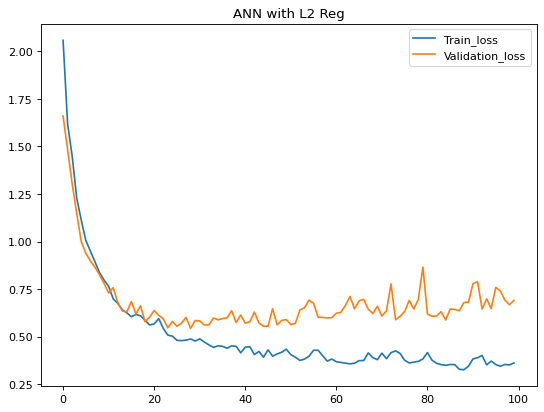

In [153]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(trainer.train_loss[:],label="Train_loss")
plt.plot(trainer.val_loss[:],label="Validation_loss")
# plt.axvline(x=10 , color='r')
plt.legend(['Train_loss','Validation_loss'])
plt.title('ANN with L2 Reg')
plt.show()

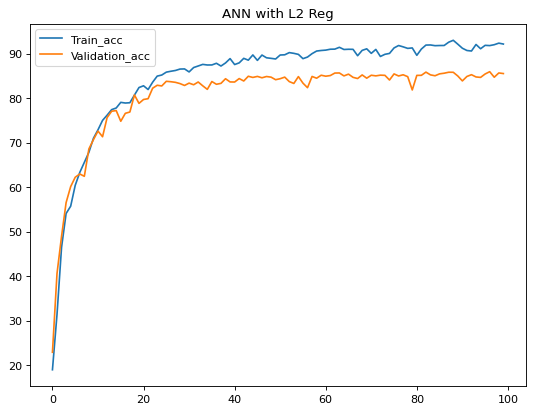

In [154]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.plot(trainer.train_acc,label="Train_acc")
plt.plot(trainer.val_acc,label="Validation_acc")
# plt.axvline(x=10 , color='r')

plt.legend(['Train_acc','Validation_acc'])
plt.title('ANN with L2 Reg')
plt.show()

In [ ]:
trainer